# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---

## **Project Part 2: Seal Call Discrimination**

### **Objective**
The aim of this project is to analyze a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. While creating a fully functional detector is the ultimate goal, it may not be the final outcome of this project.

#### **Step A: Data Pre-processing**

This step is completed in notebook `data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

#### **Step B: Model Training**
1. **Dataset Utilisation**:
   - Use the prepared spectrogram dataset to train the machine learning model.

3. **Evaluation**:
   - Test the model’s performance on a separate test dataset.

#### **Step C: Refine**
1. **Parameter Tuning**:
   - Adjust parameters in the data extraction/spectrogram creation process (e.g., `nfft`, `noverlap`).
   - Manage computational costs by splitting `.wav` files using tools like `pydub`.

2. **Validation**:
   - Apply the Rupe B/No Call classifier on an entire `.wav` file (held back during training).
   - Ensure no false positives due to the presence of other annotated calls.

In [267]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K



---

### **Step B: Model Training** 

---

In [268]:
# Load in processed data
df = pd.read_pickle('processed_data.pkl')
df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),Annotation,file_name,folder_name,snippet_spectrogram,snippet_times,snippet_frequencies
0,1,Spectrogram 1,1,4.136987,4.657535,173.956,286.792,0.5205,112.836,-82.85,G Rupe,5711.211013040024,Guttural rupe,"[[10.569122314453125, 4.712647438049316, 1.273...","[4.131708333333333, 4.1445, 4.157291666666667,...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
1,2,Spectrogram 1,1,3.789955,4.264841,371.419,451.345,0.4749,79.926,-92.16,G Rupe,5711.211013040024,Guttural rupe,"[[42.39829635620117, 55.68126678466797, 83.361...","[3.7863333333333333, 3.799125, 3.8119166666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
2,3,Spectrogram 1,1,14.840188,15.406398,136.660,445.248,0.5662,308.588,-88.96,G Rupe,5711.211013040024,Guttural rupe,"[[29.341825485229492, 8.032623291015625, 43.69...","[14.838333333333333, 14.851125, 14.86391666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
3,4,Spectrogram 1,1,24.543802,25.082615,167.519,392.347,0.5388,224.828,-86.10,G Rupe,5711.211013040024,Guttural rupe,"[[0.28541040420532227, 0.41072168946266174, 2....","[24.547208333333334, 24.56, 24.572791666666667...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."
4,5,Spectrogram 1,1,35.989220,36.573694,119.027,436.431,0.5845,317.405,-80.18,G Rupe,5711.211013040024,Guttural rupe,"[[13.951732635498047, 23.50061798095703, 20.28...","[35.982958333333336, 35.99575, 36.008541666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14..."


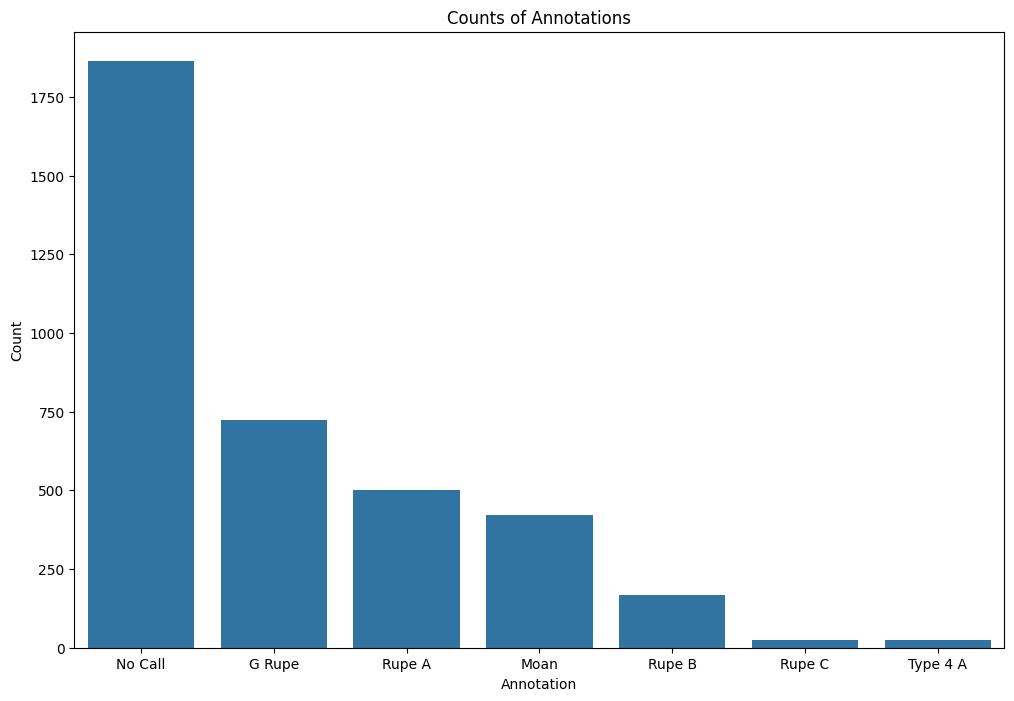

In [269]:
# Count the values
annotation_counts = df['Annotation'].value_counts()

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=annotation_counts.index, y=annotation_counts.values, ax=ax)

ax.set_xlabel("Annotation")
ax.set_ylabel("Count")
ax.set_title("Counts of Annotations")
plt.show()

In [270]:
# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Annotation'], prefix='Annotation')

In [271]:
# Get the shapes
shapes = df['snippet_spectrogram'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)

# Count unique shapes
print("Unique shapes in 'snippet_spectrogram':")
print(shapes.value_counts())

Unique shapes in 'snippet_spectrogram':
snippet_spectrogram
(42, 84)    3728
Name: count, dtype: int64


In [272]:
X = df[['snippet_spectrogram']].to_numpy()

# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape)


(3728,)
(3728, 42, 84)


In [273]:
# Reshape to 2D for MinMaxScaler
X_reshaped = X.reshape(-1, X.shape[-2])  # Shape: (3742 * 42, 84)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to the original shape
X = X_scaled.reshape(X.shape)

X.shape

(3728, 42, 84)

In [274]:
X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]]  # Select annotation columns

# `y` contains one-hot encoded labels
stratify_labels = y.idxmax(axis=1)

# First split: Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels,
    shuffle=True
)

# Second split: Train/Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=42,
    stratify=y_train.idxmax(axis=1),
    shuffle=True
)

# Output shapes
train_shape = X_train.shape
val_shape = X_val.shape
test_shape = X_test.shape

train_shape, val_shape, test_shape

((2236, 42, 84), (746, 42, 84), (746, 42, 84))

In [275]:
stratify_labels

0        Annotation_G Rupe
1        Annotation_G Rupe
2        Annotation_G Rupe
3        Annotation_G Rupe
4        Annotation_G Rupe
               ...        
3723    Annotation_No Call
3724    Annotation_No Call
3725    Annotation_No Call
3726    Annotation_No Call
3727    Annotation_No Call
Length: 3728, dtype: object

#### **Model 1**

In [276]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_' + which], label='Validation Loss')
    except:
        pass
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Accuracy')
    try:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    except:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

In [277]:
def confusion_matrix_plot():
    # Predict probabilities and convert to class predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Convert y_test one-hot to integer-encoded labels
    y_true = np.argmax(y_test, axis=1)

    # Extract the real class names
    class_names = [col.replace("Annotation_", "") for col in y_test.columns]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names,
                yticklabels=class_names,
                cmap="viridis", ax=ax)

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()


In [278]:
input_shape = (42, 84, 1)
num_classes = len(stratify_labels.unique())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [279]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 42, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 21, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 21, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 10, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 10, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 5, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,927 (1.66 MB)

 Trainable params: 433,927 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [280]:
# Define focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

In [281]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss= focal_loss(gamma=2., alpha=0.25),  #from_logits=False as softmax is on the output of the CNN
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

In [282]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [283]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5683 - auc: 0.6254 - f1_score: 0.1362 - loss: 0.0429 - precision: 0.6348 - recall: 0.2286 - val_accuracy: 0.6875 - val_auc: 0.8609 - val_f1_score: 0.2670 - val_loss: 0.0185 - val_precision: 0.8774 - val_recall: 0.6071
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6997 - auc: 0.8171 - f1_score: 0.2602 - loss: 0.0207 - precision: 0.8703 - recall: 0.5188 - val_accuracy: 0.7857 - val_auc: 0.8799 - val_f1_score: 0.3326 - val_loss: 0.0176 - val_precision: 0.9353 - val_recall: 0.6451
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7738 - auc: 0.8593 - f1_score: 0.3100 - loss: 0.0163 - precision: 0.9083 - recall: 0.6269 - val_accuracy: 0.7723 - val_auc: 0.8810 - val_f1_score: 0.3209 - val_loss: 0.0140 - val_precision: 0.8571 - val_recall: 0.6830
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8280 - auc: 0.8987 - f1_score: 0.4126 - loss: 0.0124 - precision: 0.9100 - recall: 0.7102

In [284]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8875 - auc: 0.9002 - f1_score: 0.5529 - loss: 0.0196 - precision: 0.9033 - recall: 0.8699


{'accuracy': 0.9061661958694458,
 'auc': 0.9456710815429688,
 'f1_score': 0.584378182888031,
 'loss': 0.014761611819267273,
 'precision': 0.9221140742301941,
 'recall': 0.8887399435043335}

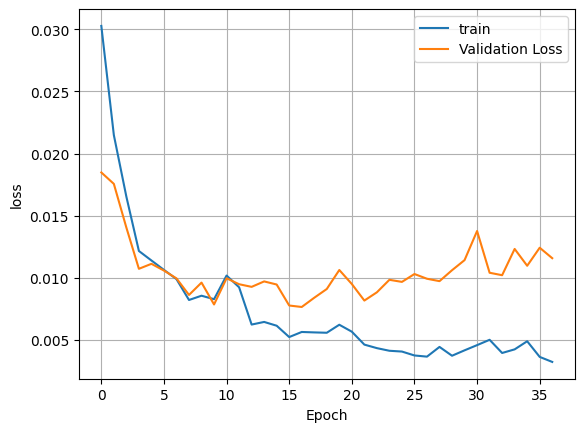

In [285]:
plot_loss(history)

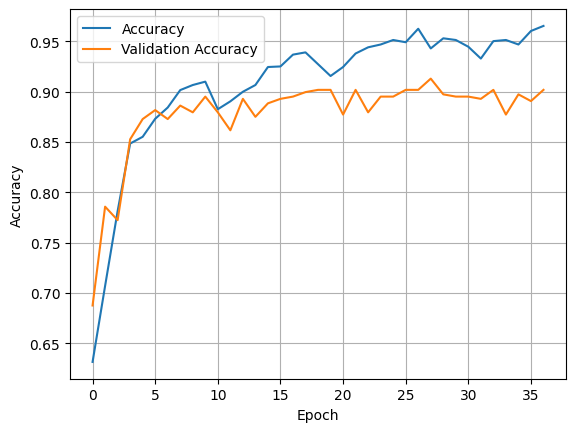

In [286]:
plot_accuracy(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

      G Rupe       0.89      0.90      0.89       145
        Moan       0.85      0.81      0.83        85
     No Call       1.00      0.98      0.99       373
      Rupe A       0.84      0.87      0.85       100
      Rupe B       0.49      0.73      0.59        33
      Rupe C       0.00      0.00      0.00         5
    Type 4 A       1.00      0.20      0.33         5

    accuracy                           0.91       746
   macro avg       0.72      0.64      0.64       746
weighted avg       0.91      0.91      0.91       746



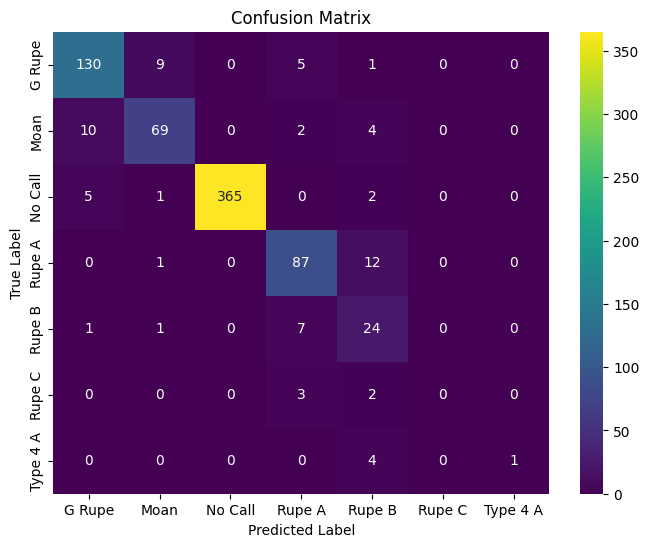

In [287]:
confusion_matrix_plot()

#### **Model 2**

In [288]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # from_logits=False as softmax is on the output of the CNN
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),  # Add AUC for multi-class classification
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

In [289]:
# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [290]:
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[callback])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9442 - auc: 0.9908 - f1_score: 0.8177 - loss: 913.1659 - precision: 0.9548 - recall: 0.9355 - val_accuracy: 0.8951 - val_auc: 0.9207 - val_f1_score: 0.5811 - val_loss: 1.1775 - val_precision: 0.9103 - val_recall: 0.8839
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9682 - auc: 0.9741 - f1_score: 0.7789 - loss: 23.2341 - precision: 0.9773 - recall: 0.9612 - val_accuracy: 0.8884 - val_auc: 0.9382 - val_f1_score: 0.5722 - val_loss: 0.9137 - val_precision: 0.8995 - val_recall: 0.8795
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9570 - auc: 0.9810 - f1_score: 0.7298 - loss: 0.1733 - precision: 0.9658 - recall: 0.9396 - val_accuracy: 0.8996 - val_auc: 0.9426 - val_f1_score: 0.5798 - val_loss: 0.9879 - val_precision: 0.9068 - val_recall: 0.8906
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9704 - auc: 0.9453 - f1_score: 0.7940 - loss: 0.1049 - precision: 0.9743 - recall: 0.9

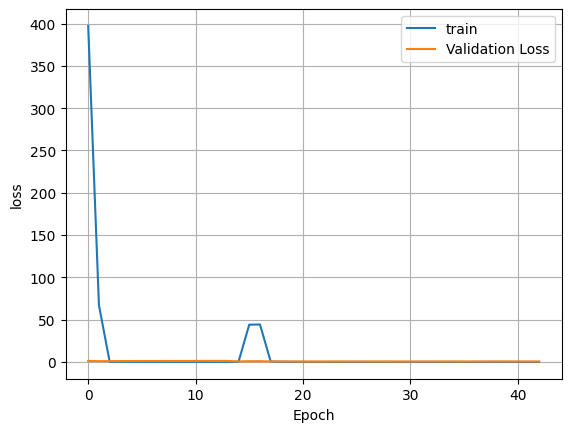

In [291]:
plot_loss(history)

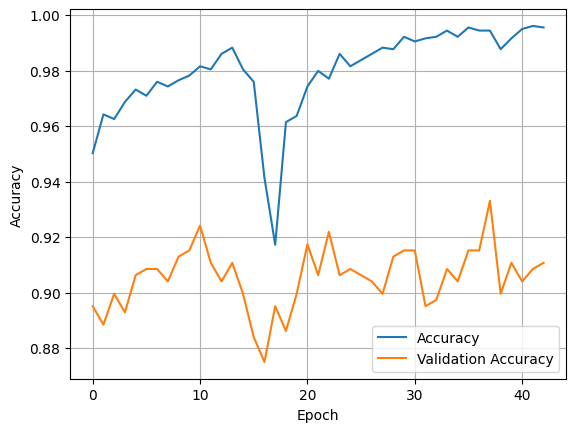

In [292]:
plot_accuracy(history)

In [293]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9136 - auc: 0.8560 - f1_score: 0.6253 - loss: 483.6840 - precision: 0.9207 - recall: 0.9089


{'accuracy': 0.919571042060852,
 'auc': 0.921721339225769,
 'f1_score': 0.660335123538971,
 'loss': 800.831787109375,
 'precision': 0.9256756901741028,
 'recall': 0.9182305335998535}

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

      G Rupe       0.93      0.90      0.92       145
        Moan       0.85      0.86      0.85        85
     No Call       0.99      0.99      0.99       373
      Rupe A       0.89      0.85      0.87       100
      Rupe B       0.60      0.73      0.66        33
      Rupe C       0.00      0.00      0.00         5
    Type 4 A       0.22      0.40      0.29         5

    accuracy                           0.92       746
   macro avg       0.64      0.68      0.65       746
weighted avg       0.92      0.92      0.92       746



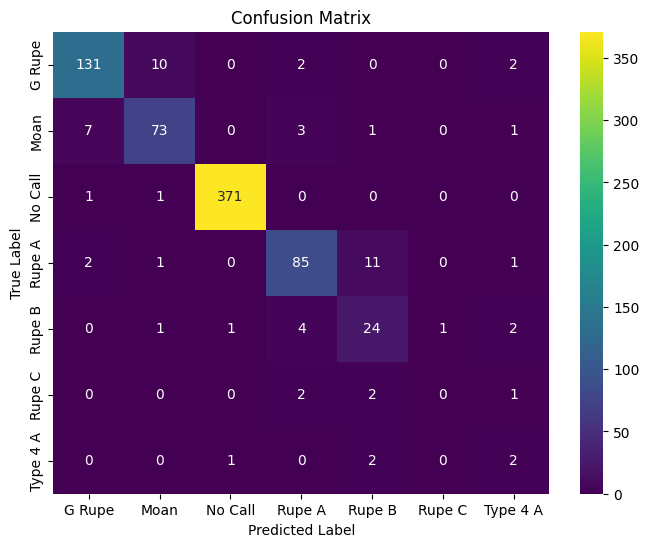

In [294]:
confusion_matrix_plot()

#### **Model 3: EfficientNet**

In [295]:
# Removed the data augmentation as the model is performing poorly.

# Training data generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Validation data generator
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Test data generator
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [296]:
# Add a channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [297]:
train_iterator = train_datagen.flow(X_train, y_train, batch_size=30, shuffle=True)
val_iterator = val_datagen.flow(X_val, y_val, batch_size=len(y_val), shuffle=True)
test_iterator = test_datagen.flow(X_test, y_test, batch_size=len(y_test), shuffle=True)

In [298]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Load the EfficientNetB4 base model
weights_path = 'noisy_student_efficientnet_b4.h5'

base_model = EfficientNetB4(
    weights=weights_path,
    include_top=False,
    pooling='avg',
)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new custom top layers
model = keras.models.Sequential([
    base_model,                          # Add the base model
    #layers.Dropout(0.2),                 # Add Dropout
    layers.Dense(num_classes, activation='softmax')  # Add custom Dense layer for classification
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(thresholds=0.5, name="precision"),
        tf.keras.metrics.Recall(thresholds=0.5, name="recall"),
        tf.keras.metrics.AUC(multi_label=True, name="auc"),
        tf.keras.metrics.F1Score(threshold=0.5, average='macro', name="f1_score"),
    ]
)

# Display the model architecture
model.summary()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2403759946.py, line 24)

In [260]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

callback_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_EN.keras', monitor='val_loss', save_best_only=True)

In [261]:
history = model.fit(
    train_iterator,
    batch_size=32,
    epochs=20,
    validation_data=val_iterator,
    callbacks=[early_stop, callback_modelcheckpoint]
)

Epoch 1/20


c:\Users\Damien\ATU\machine-learning-project-2\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.0677 - auc: 0.5158 - f1_score: 0.0385 - loss: 3.0368 - precision: 0.1178 - recall: 0.0379 - val_accuracy: 0.1126 - val_auc: 0.5251 - val_f1_score: 0.0000e+00 - val_loss: 2.0149 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.0938 - auc: 0.5051 - f1_score: 0.0283 - loss: 2.5161 - precision: 0.1541 - recall: 0.0314 - val_accuracy: 0.5027 - val_auc: 0.5137 - val_f1_score: 0.0000e+00 - val_loss: 1.6719 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.3527 - auc: 0.5059 - f1_score: 0.0180 - loss: 2.0065 - precision: 0.1025 - recall: 0.0205 - val_accuracy: 0.4960 - val_auc: 0.5131 - val_f1_score: 0.0000e+00 - val_loss: 1.5420 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.4335 - auc: 0.4893 - f1_score: 0.0315 - loss: 1.8961 - p

In [262]:
saved_model = load_model('best_model_EN.keras')

In [ ]:
saved_model.evaluate(test_iterator, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4906 - auc: 0.5405 - f1_score: 0.0158 - loss: 1.8560 - precision: 0.3235 - recall: 0.0295


{'accuracy': 0.4906166195869446,
 'auc': 0.540513277053833,
 'f1_score': 0.0157818291336298,
 'loss': 1.8560205698013306,
 'precision': 0.3235294222831726,
 'recall': 0.02949061617255211}

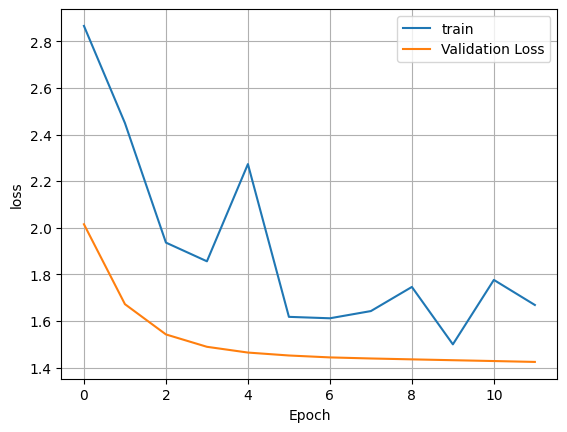

In [ ]:
plot_loss(history)

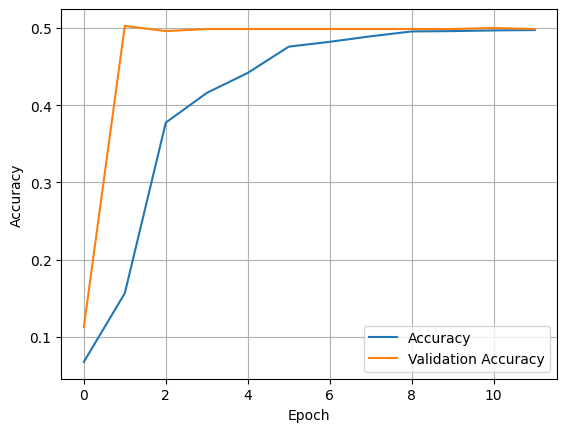

In [ ]:
plot_accuracy(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step
Classification Report:
              precision    recall  f1-score   support

      G Rupe       0.40      0.01      0.03       145
        Moan       0.00      0.00      0.00        85
     No Call       0.50      0.98      0.66       373
      Rupe A       0.00      0.00      0.00       100
      Rupe B       0.00      0.00      0.00        33
      Rupe C       0.00      0.00      0.00         5
    Type 4 A       0.00      0.00      0.00         5

    accuracy                           0.49       746
   macro avg       0.13      0.14      0.10       746
weighted avg       0.33      0.49      0.34       746



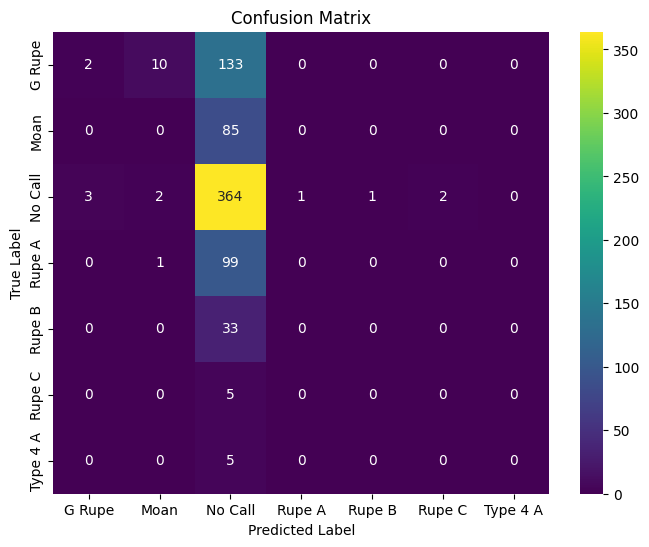

In [ ]:
confusion_matrix_plot()

#### **Model 4**

---

### **Step C: Refine**

---

---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)





---

# END